In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Metrics results class

### Metrics types

In [3]:
from pulsar_metrics.metrics.enums import MetricsType

In [4]:
MetricsType._member_names_

['performance', 'drift', 'custom', 'statistics']

### Metric data structure

In [5]:
from pulsar_metrics.metrics.base import MetricResults

In [6]:
results = MetricResults(
    metric_type = 'custom', metric_name = 'accuracy')
results

MetricResults(metric_type='custom', metric_name='accuracy', feature_name=None, metric_value=None, drift_status=None, threshold=None, conf_int=None)

## Loading datasets

In [7]:
data_ref = pd.read_csv('data/california_ref.csv')
data_new = pd.read_csv('data/california_new.csv')

In [8]:
data_ref.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,pred_timestamp,clf_target,y_pred_proba,y_pred,identifier,model_id,model_version
0,4.1083,6.0,3.933941,1.152620,1200.0,2.733485,34.14,-118.26,2020-05-01 00:00:00,1,0.79,0,0,1,2
1,3.0080,7.0,3.854620,1.054348,2287.0,3.107337,34.15,-118.27,2020-05-01 00:30:00,1,0.88,1,1,1,2
2,2.6673,25.0,3.192040,1.105473,2843.0,2.828856,34.13,-118.26,2020-05-01 01:00:00,1,0.98,1,2,1,2
3,2.5000,37.0,3.066519,1.042129,1185.0,2.627494,34.13,-118.26,2020-05-01 01:30:00,1,0.95,1,3,1,2
4,1.2188,37.0,2.882353,1.088235,194.0,2.852941,34.13,-118.26,2020-05-01 02:00:00,1,0.68,0,4,1,2


## Summary statistics

In [9]:
from pulsar_metrics.metrics.statistics import FeatureSummary

In [10]:
statistics = FeatureSummary(feature_name='HouseAge')

In [11]:
statistics.evaluate(current = data_new, reference=data_ref)

In [12]:
statistics.results_to_pandas()

,metric_type,metric_name,feature_name,metric_value,drift_status,threshold,conf_int
0,statistics,mean,HouseAge,26.246864,None,29.308774,None
1,statistics,median,HouseAge,25.000000,None,31.000000,None
2,statistics,std,HouseAge,12.910057,None,11.119151,None
3,statistics,skewness,HouseAge,0.357473,None,-0.212044,None
4,statistics,kurtosis,HouseAge,-0.695142,None,-0.481793,None
5,statistics,P25.0,HouseAge,16.000000,None,21.000000,None
6,statistics,P95.0,HouseAge,52.000000,None,47.000000,None
7,statistics,count,HouseAge,8928.000000,None,NaN,None


## Drift Class

In [13]:
from pulsar_metrics.metrics.drift import DriftTestMetric, DriftMetric
from pulsar_metrics.metrics.enums import DriftMetricsFuncs, DriftTestMetricsFuncs

In [14]:
DriftMetricsFuncs._member_names_

['kl', 'psi', 'wasserstein', 'mmd']

In [15]:
DriftTestMetricsFuncs._member_names_

['ttest', 'manwu', 'levene', 'bftest', 'ks_2samp', 'CvM', 'chi2']

### Test Drift metrics

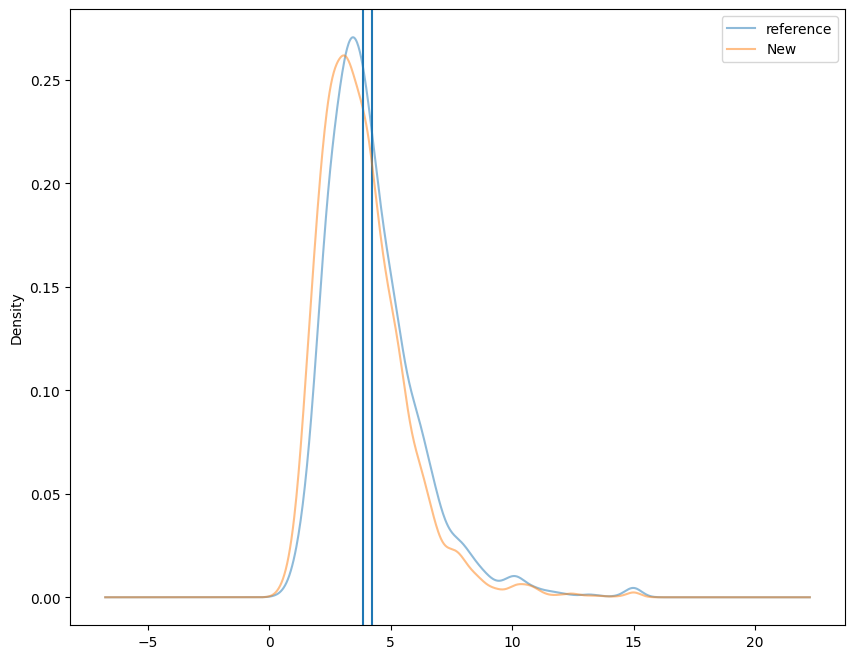

In [16]:
feature_name = 'MedInc'
#feature_name = 'Population'
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
data_ref[feature_name].plot.density(ax = ax, alpha = 0.5, label = 'reference')
plt.axvline(data_ref[feature_name].mean())
data_new[feature_name].plot.density(ax = ax, alpha = 0.5, label = 'New')
plt.axvline(data_new[feature_name].mean())
#ax.set_xlim((0, 6000))
plt.legend()

In [17]:

driftTest = DriftTestMetric(metric_name = 'ttest', feature_name = feature_name)
driftTest.evaluate(alpha = 0.05, current = data_new, reference = data_ref)

MetricResults(metric_type='drift', metric_name='ttest', feature_name='MedInc', metric_value=2.1877815394701083e-35, drift_status=True, threshold=0.05, conf_int=None)

In [18]:
driftTest = DriftTestMetric(metric_name = 'CvM', feature_name = feature_name)
driftTest.evaluate(alpha = 0.05, current = data_new, reference = data_ref)

MetricResults(metric_type='drift', metric_name='CvM', feature_name='MedInc', metric_value=5.027078753272463e-10, drift_status=True, threshold=0.05, conf_int=None)

### Non test drift metrics

In [19]:
drift = DriftMetric(metric_name = 'wasserstein', feature_name = feature_name)
drift.evaluate(current = data_new, reference = data_ref, threshold = 0.2, upper_bound = True)

MetricResults(metric_type='drift', metric_name='wasserstein', feature_name='MedInc', metric_value=0.3918793415071247, drift_status=False, threshold=0.2, conf_int=None)

In [20]:
drift = DriftMetric(metric_name = 'mmd', feature_name = feature_name)
drift.evaluate(current = data_new, reference = data_ref, threshold = 0.2, upper_bound = True, kernel='rbf')

MetricResults(metric_type='drift', metric_name='mmd', feature_name='MedInc', metric_value=0.0075224855632681775, drift_status=True, threshold=0.2, conf_int=None)

## Custom metric class    

In [21]:
from pulsar_metrics.metrics.drift import CustomDriftMetric

In [22]:
@CustomDriftMetric
def test_custom(current, reference, multiple=3, **kwargs):
    return multiple*np.max(current - reference)

In [23]:
cus = test_custom(metric_name = 'test', feature_name = feature_name)

In [24]:
cus.evaluate(current = data_new, reference = data_ref, threshold = 1, multiple=0.5)

MetricResults(metric_type='custom', metric_name='test', feature_name='MedInc', metric_value=5.93755, drift_status=False, threshold=1.0, conf_int=None)

## Performance metrics

### Implemented metrics

In [25]:
from pulsar_metrics.metrics.enums import PerformanceMetricsFuncs

In [26]:
PerformanceMetricsFuncs._member_names_

['accuracy',
 'precision',
 'recall',
 'f1',
 'log_loss',
 'auc',
 'aucpr',
 'brier',
 'mse',
 'mae',
 'mape',
 'r2']

### Exemple performance metric

In [27]:
from pulsar_metrics.metrics.performance import PerformanceMetric

In [28]:
precision = PerformanceMetric(metric_name = 'precision', y_name = 'clf_target')

In [29]:
precision.evaluate(current = data_new, bootstrap=True, average = 'micro', threshold = [0.45, 0.5])

MetricResults(metric_type='performance', metric_name='precision', feature_name='prediction', metric_value=0.6114471326164874, drift_status=True, threshold=[0.45, 0.5], conf_int=[0.6016577060931899, 0.6193520385304659])

## Running an analyzer with multiple metrics

In [30]:
from pulsar_metrics.analyzers.base import Analyzer

In [31]:
analysis = Analyzer(name = 'First Analyzer', description='My first Analyzer', model_id = 1, model_version=2)

In [32]:
analysis.add_drift_metrics(metrics_list=['wasserstein', 'ttest', 'ks_2samp', 'mmd'], features_list=['AveBedrms', 'MedInc']);
analysis.add_performance_metrics(metrics_list=['accuracy'], y_name = 'clf_target');

Drift metric 'wasserstein' for feature 'AveBedrms' added to the analyzer list
Drift metric 'wasserstein' for feature 'MedInc' added to the analyzer list
Drift metric 'ttest' for feature 'AveBedrms' added to the analyzer list
Drift metric 'ttest' for feature 'MedInc' added to the analyzer list
Drift metric 'ks_2samp' for feature 'AveBedrms' added to the analyzer list
Drift metric 'ks_2samp' for feature 'MedInc' added to the analyzer list
Drift metric 'mmd' for feature 'AveBedrms' added to the analyzer list
Drift metric 'mmd' for feature 'MedInc' added to the analyzer list


In [33]:
analysis.run(reference = data_ref, current = data_new, options = {'ttest': {'alpha': 0.01, 'equal_var': False}, 'mmd': {'kernel': 'rbf'}})

/Users/adelbenlagra/Tresorit/Documents/Mandats/RocketScience/MPM/pulsar_metrics/pulsar_metrics/metrics/statistics.py:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  threshold = func(reference[self._feature_name])
/Users/adelbenlagra/Tresorit/Documents/Mandats/RocketScience/MPM/pulsar_metrics/pulsar_metrics/metrics/statistics.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  metric_value=func(current[self._feature_name]),
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


In [34]:
analysis._metadata

{'name': 'First Analyzer',
 'description': 'My first Analyzer',
 'model_id': 1,
 'model_version': 2,
 'period_start': Timestamp('2020-09-01 00:00:00'),
 'period_end': Timestamp('2021-03-05 23:30:00'),
 'eval_timestamp': datetime.datetime(2023, 3, 12, 19, 26, 35, 281043),
 'options': {'ttest': {'alpha': 0.01, 'equal_var': False},
  'mmd': {'kernel': 'rbf'}}}

In [35]:
results = analysis.results_to_pandas()
results

,metric_type,metric_name,feature_name,metric_value,drift_status,threshold,conf_int,model_id,model_version,period_start,period_end,eval_timestamp,options
0,statistics,mean,MedInc,3.841661e+00,None,4.233536,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
1,statistics,median,MedInc,3.558400e+00,None,3.846350,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
2,statistics,std,MedInc,1.796196e+00,None,1.926329,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
3,statistics,skewness,MedInc,1.561581e+00,None,1.673273,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
4,statistics,kurtosis,MedInc,4.818001e+00,None,4.974421,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,drift,ks_2samp,AveBedrms,9.000303e-14,True,0.050000,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
118,drift,ks_2samp,MedInc,1.402674e-28,True,0.050000,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
119,drift,mmd,AveBedrms,6.912463e-04,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
120,drift,mmd,MedInc,7.522486e-03,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN


In [36]:
results.loc[(results.metric_type=='statistics') & (results.metric_name=='count')]

,metric_type,metric_name,feature_name,metric_value,drift_status,threshold,conf_int,model_id,model_version,period_start,period_end,eval_timestamp,options
7,statistics,count,MedInc,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
15,statistics,count,HouseAge,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
23,statistics,count,AveRooms,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
31,statistics,count,AveBedrms,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
39,statistics,count,Population,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
47,statistics,count,AveOccup,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
55,statistics,count,Latitude,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
63,statistics,count,Longitude,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
64,statistics,count,pred_timestamp,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
72,statistics,count,y_pred_proba,8928.0,None,NaN,None,1,2,2020-09-01,2021-03-05 23:30:00,2023-03-12 19:26:35.281043,NaN
